# Energy estimation

**WARNING**

This is still a work-in-progress, it will evolve with the pipeline comparisons and converge with ctaplot+cta-benchmarks.

Part of this notebook is performed by `protopipe.scripts.model_diagnostics`

Also: this notebook doesn't actually look at the estimated values in DL2 data, but rather the properties of the training sample used to build the regressor.

**Author(s):**
    
- Dr. Michele Peresano (CEA-Saclay/IRFU/DAp/LEPCHE), 2020

based on previous work by J. Lefacheur.

**Description:**

This notebook contains benchmarks for the _protopipe_ pipeline regarding energy estimation.
Additional information is provided by protopipe.scripts.model_diagnostics, which will eventually merge here.

Note that:
    - a more general set of benchmarks is being defined in cta-benchmarks/ctaplot,
    - follow [this](https://www.overleaf.com/16933164ghbhvjtchknf) document by adding new benchmarks or proposing new ones.

**Requirements:**

To run this notebook you will need a set of trained data produced on the grid with protopipe.
The MC production to be used and the appropriate set of files to use for this notebook can be found [here](https://forge.in2p3.fr/projects/step-by-step-reference-mars-analysis/wiki#The-MC-sample ).

The data format required to run the notebook is the current one used by _protopipe_ .
Later on it will be the same as in _ctapipe_ + _pyirf_.

**Development and testing:**  

For the moment this notebook is optimized to work only on files produced from LSTCam + NectarCam telescope configurations.  
As with any other part of _protopipe_ and being part of the official repository, this notebook can be further developed by any interested contributor.  
The execution of this notebook is not currently automatic, it must be done locally by the user - preferably _before_ pushing a pull-request.  
**IMPORTANT:** Please, if you wish to contribute to this notebook, before pushing anything to your branch (better even before opening the PR) clear all the output and remove any local directory paths that you used for testing (leave empty strings).

**TODO:**  
* update everything...
* merge model diagnostics products
* add remaining benchmarks from CTA-MARS comparison
* same for EventDisplay

## Imports

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm, PowerNorm
count = 0
cmap = dict()
for key in colors.cnames:
    if 'dark' in key:
    #if key in key:
        cmap[count] = key
        count = count + 1
#cmap = {'black': 0, 'red': 1, 'blue': 2, 'green': 3}
cmap = {0: 'black', 1: 'red', 2: 'blue', 3: 'green'}
import os
import numpy as np
import pandas as pd
from pathlib import Path

## Functions

In [2]:
def plot_profile(ax, data, xcol, ycol, n_xbin, x_range, logx=False, **kwargs):
    color = kwargs.get('color', 'red')
    label = kwargs.get('label', '')
    fill = kwargs.get('fill', False)
    alpha = kwargs.get('alpha', 1)
    xlabel = kwargs.get('xlabel', '')
    ylabel = kwargs.get('ylabel', '')
    xlim = kwargs.get('xlim', None)
    ms = kwargs.get('ms', 8)
    
    if logx is False:
        bin_edges = np.linspace(x_range[0], x_range[-1], n_xbin, True)
        bin_center = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        bin_width = bin_edges[1:] - bin_edges[:-1]
    else:
        bin_edges = np.logspace(np.log10(x_range[0]), np.log10(x_range[-1]), n_xbin, True)
        bin_center = np.sqrt(bin_edges[1:] * bin_edges[:-1])
        bin_width = bin_edges[1:] - bin_edges[:-1]
    
    y = []
    yerr = []
    for idx in range(len(bin_center)):
        counts = data[ (data[xcol] > bin_edges[idx]) & (data[xcol] <= bin_edges[idx+1]) ][ycol]
        y.append(counts.mean())
        yerr.append(counts.std() / np.sqrt(len(counts)))
        
    ax.errorbar(x=bin_center, y=y, xerr=bin_width / 2., yerr=yerr, label=label, fmt='o', color=color, ms=ms)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if logx is True:
        ax.set_xscale('log')
    ax.legend(loc='upper right', framealpha=1, fontsize='medium')
    #ax.grid(which='both')
    return ax

## Load

First we check if a _plots_ folder exists already.  
If not, we create it.

In [7]:
Path("./plots_energy_estimation").mkdir(parents=True, exist_ok=True)

Setup for data loading

In [10]:
mode = 'tail'

# Please, if you modify this notebook in a PR cleanup these two variables
parent = '' # your analysis parent folder (better use an absolute path)
config = '' # analysis descriptor to be used as suffix in the plots

# Load data
data_dir = f'{parent}/{config}/data/TRAINING/for_energy_estimation'
myfile = 'dl1_{}_gamma_merged.h5'.format(mode)

data_image = pd.read_hdf(os.path.join(data_dir,myfile), key='feature_events_LSTCam')
print('#Images={}'.format(len(data_image)))
data_image['log10_charge'] = np.log10(data_image['sum_signal_cam'])

#Images=856836


## Benchmarks

### Charge profile for the LSTs

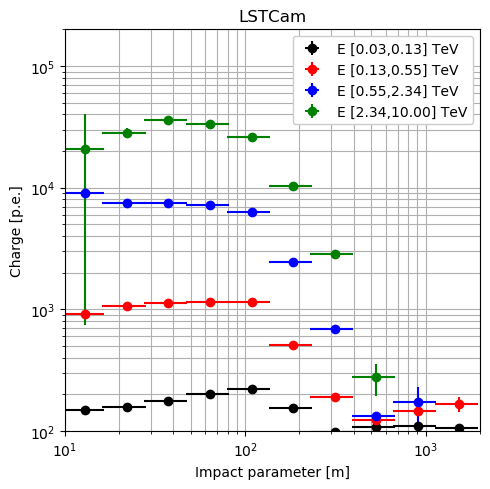

In [16]:
tel_ids = [1, 2, 3, 4] # WARNING! These are only the LSTs!
n_feature = len(tel_ids)
nrows = int(n_feature / 2) if n_feature % 2 == 0 else int((n_feature + 1) / 2)

emin = 0.03
emax = 10
nbin = 4
energy_range = np.logspace(np.log10(emin), np.log10(emax), nbin + 1, True)

fig = plt.figure(figsize=(5,5))
plt.title("LSTCam")
ax = plt.gca()
for jdx in range(0, len(energy_range) - 1):
        
    data_sel = data_image[data_image['N_LST'] >= 2]
    data_sel = data_sel[(data_sel['mc_energy'] >= energy_range[jdx]) & 
                        (data_sel['mc_energy'] < energy_range[jdx + 1])]
        
    xbins = 10 + 1
    xrange = [10, 2000]
    opt = {'xlabel': 'Impact parameter [m]', 'ylabel': 'Charge [p.e.]', 'color': cmap[jdx],
           'label': 'E [{:.2f},{:.2f}] TeV'.format(energy_range[jdx], energy_range[jdx+1]),
           'ms': 6}
    plot_profile(ax, data=data_sel,
                 xcol='impact_dist', ycol='sum_signal_cam',
                 n_xbin=xbins, x_range=xrange, logx=True, **opt)
    #ax.grid(which='both')
    ax.set_yscale('log')
    ax.set_yscale('log')
    ax.set_ylim([100, 2. * 100000.])
    ax.set_xlim([10, 2000])

ax.grid(which='both')
plt.tight_layout()

fig.savefig(f"./plots_energy_estimation/charge_profile_{config}.png")